In [1]:
# Importing all necessary libraries
import numpy as np
import pandas as pd
import cv2 as cv # pip install opencv-python
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests

from PIL import Image
from io import BytesIO

from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense, Input
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
#from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.layers.pooling import GlobalAveragePooling2D

warnings.filterwarnings('ignore')

Using TensorFlow backend.


Total number of categories: 149
Total number of images in dataset: 10693


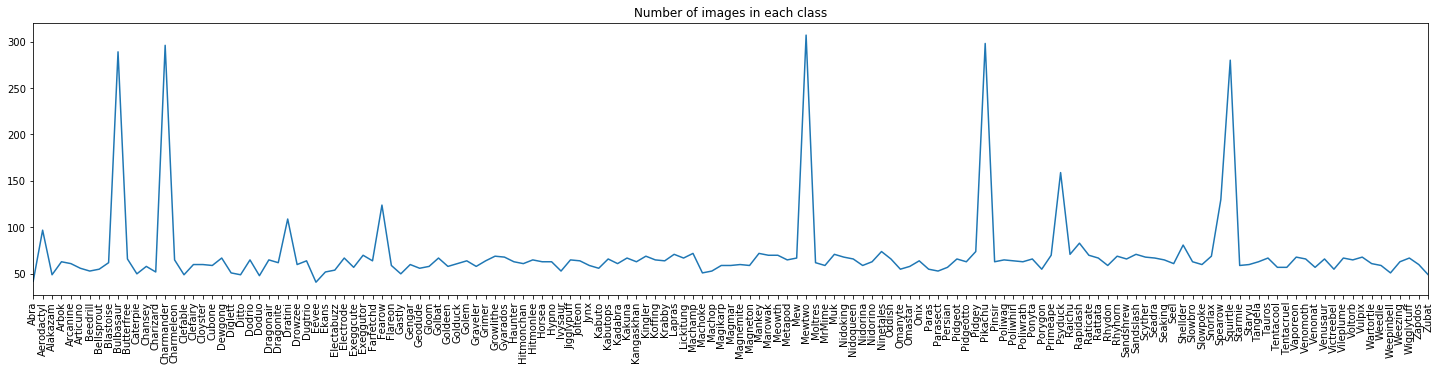

In [2]:
# A little bit of data exploration
path = '/root/userspace/private/competition/dataset' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [3]:
# Sort our "counts" dictionary and selecting 5 classes with most number of images
#imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
#imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:150]
imbalanced = sorted(counts.items(), key = lambda x: x[0], reverse = False)[:149]
print(imbalanced)

# Taking only labels, it will come in handy in future
imbalanced = [i[0] for i in imbalanced]
print(imbalanced)

[('Abra', 42), ('Aerodactyl', 97), ('Alakazam', 49), ('Arbok', 63), ('Arcanine', 61), ('Articuno', 56), ('Beedrill', 53), ('Bellsprout', 55), ('Blastoise', 62), ('Bulbasaur', 289), ('Butterfree', 66), ('Caterpie', 50), ('Chansey', 58), ('Charizard', 52), ('Charmander', 296), ('Charmeleon', 65), ('Clefable', 49), ('Clefairy', 60), ('Cloyster', 60), ('Cubone', 59), ('Dewgong', 67), ('Diglett', 51), ('Ditto', 49), ('Dodrio', 65), ('Doduo', 48), ('Dragonair', 65), ('Dragonite', 62), ('Dratini', 109), ('Drowzee', 60), ('Dugtrio', 64), ('Eevee', 41), ('Ekans', 52), ('Electabuzz', 54), ('Electrode', 67), ('Exeggcute', 57), ('Exeggutor', 70), ('Farfetchd', 64), ('Fearow', 124), ('Flareon', 59), ('Gastly', 50), ('Gengar', 60), ('Geodude', 56), ('Gloom', 58), ('Golbat', 67), ('Goldeen', 58), ('Golduck', 61), ('Golem', 64), ('Graveler', 58), ('Grimer', 64), ('Growlithe', 69), ('Gyarados', 68), ('Haunter', 63), ('Hitmonchan', 61), ('Hitmonlee', 65), ('Horsea', 63), ('Hypno', 63), ('Ivysaur', 53), 

In [4]:
X = [] # List for images
Y = [] # List for labels

# Loop through all classes
for c in classes:
    # We take only classes that we defined in 'imbalanced' list
    if c in imbalanced:
        dir_path = os.path.join(path, c)
        label = imbalanced.index(c) # Our label is an index of class in 'imbalanced' list
        
        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            image = cv.imread(os.path.join(dir_path, i))
            
            try:
                #resized = cv.resize(image, (96, 96)) # Resizing images to (96, 96)
                resized = cv.resize(image, (196, 196)) # Resizing images to (196, 196)
                X.append(resized)
                Y.append(label)
            
            # If we can't read image - we skip it
            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                continue       
            
print('DONE')

/root/userspace/private/competition/dataset/Venomoth/bb5d47bced6e4e33a77faa17e1eec906.svg [ERROR] can't read the file
/root/userspace/private/competition/dataset/Nidoqueen/89a9c05292d84aeab91bb105da37e0c0.svg [ERROR] can't read the file
/root/userspace/private/competition/dataset/Voltorb/94f443d834f94c1e8e6b088d879646d4.gif~c200 [ERROR] can't read the file
/root/userspace/private/competition/dataset/Graveler/3fe3c6a0bbd14de89092d2c675f743c1.svg [ERROR] can't read the file
/root/userspace/private/competition/dataset/Fearow/8f2d7986ab76482fb76cac6a91b66de4.svg [ERROR] can't read the file
/root/userspace/private/competition/dataset/Fearow/2c8d5221e92444f2b9477350e405bc54.svg [ERROR] can't read the file
/root/userspace/private/competition/dataset/Kingler/a87633dcbf9643319da5d702e2e1a56c.svg [ERROR] can't read the file
/root/userspace/private/competition/dataset/Scyther/a8734f10941a4deb95fcf7388e4fe8e2.svg [ERROR] can't read the file
/root/userspace/private/competition/dataset/Exeggutor/f29

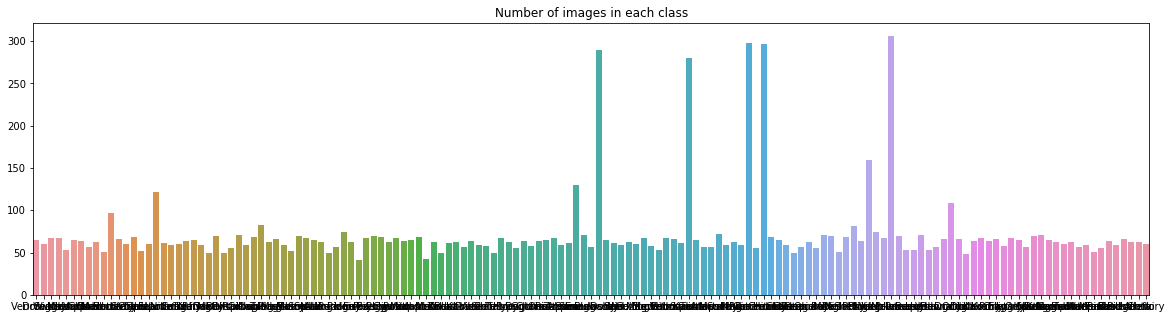

In [5]:
# Counting appearances of each label in labels list
obj = Counter(Y)

# Plotting number of images in each class
fig = plt.figure(figsize = (20, 5))
sns.barplot(x = [imbalanced[i] for i in obj.keys()], y = list(obj.values())).set_title('Number of images in each class')
plt.margins(x=0)
plt.show()

In [6]:
# Convert list with images to numpy array and reshape it 
#X = np.array(X).reshape(-1, 96, 96, 3)
X = np.array(X).reshape(-1, 196, 196, 3)

# Scaling data in array
X = X / 255.0

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(imbalanced))

# Splitting data to train and test datasets
# I'll use these datasets only for training, for final predictions I'll use random pictures from internet
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 666)

In [7]:
# Defining ImageDataGenerator Iinstance
#datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
#                            zoom_range = 0.2, # Range for random zoom 
#                            horizontal_flip = True, # Randomly flip inputs horizontally
#                            width_shift_range = 0.15, # Range for horizontal shift 
#                            height_shift_range = 0.15, # Range for vertical shift 
#                            shear_range = 0.2) # Shear Intensity
datagen = ImageDataGenerator(
                            #featurewise_center = True, 
                            #featurewise_std_normalization = True,
                            rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.5, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.5, # Range for horizontal shift 
                            height_shift_range = 0.5, # Range for vertical shift 
                            shear_range = 0.2) # Shear Intensity

datagen.fit(X_train)

# This piece of code can be used if you eant to look what your datagen doing with your images
# img = X[600]
# img = img.reshape([-1, 96, 96, 3])

# i = 0
# fig = plt.figure(figsize = (18, 8))

# for i, flow in enumerate(datagen.flow(img, batch_size = 1)):
#     fig.add_subplot(2, 5, i+1)
#     plt.imshow(np.squeeze(flow[:, :, ::-1]))
#     plt.axis('off')
#     i += 1
#     if i >= 10:
#         break

In [8]:
#model = Sequential()
#model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(96, 96, 3), kernel_initializer = 'he_normal'))
#model.add(BatchNormalization(axis = -1))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.25))
#
#model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
#model.add(BatchNormalization(axis = -1))
#model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
#model.add(BatchNormalization(axis = -1))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.25))
#
#model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
#model.add(BatchNormalization(axis = -1))
#model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
#model.add(BatchNormalization(axis = -1))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.25))
#
#model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
#model.add(BatchNormalization(axis = -1))
#model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
#model.add(BatchNormalization(axis = -1))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.25))
#
#model.add(Flatten())
#model.add(Dense(512, activation = 'relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(Dense(256, activation = 'relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(Dense(len(imbalanced), activation = 'softmax'))
#
#model.summary()
#
##checkpoint = ModelCheckpoint('../working/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
#checkpoint = ModelCheckpoint('/Users/nakayama/Desktop/lesson/advanced/work/pokemon/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
#
#model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
##history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 32), epochs = 100, validation_data = [X_test, y_test],
##                             steps_per_epoch=len(X_train) // 32, callbacks = [checkpoint])
#history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 32), epochs = 10, validation_data = [X_test, y_test],
#                             steps_per_epoch=len(X_train) // 32, callbacks = [checkpoint])

#input_tensor = Input(shape=(96, 96, 3))
input_tensor = Input(shape=(196, 196, 3))
#base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
base_model = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)

# 全結合層の新規構築
top_model = base_model.output
#top_model = GlobalAveragePooling2D()(top_model)
top_model = Flatten()(top_model)
top_model = Dense(1024, activation = 'relu')(top_model)
predictions = Dense(len(imbalanced), activation = 'softmax')(top_model)

# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

print("{}層".format(len(model.layers)))

# block14_sepconv1 層の手前まで freeze
trainable = False
for layer in model.layers:
    if layer.name == 'block14_sepconv1':
        trainable = True
    
    # block14_sepconv1 以降の層は freeze 解除
    layer.trainable = trainable

    # Batch Normalization の freeze 解除
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
    if layer.name.endswith('bn'):
        layer.trainable = True

##108層までfreeze
#for layer in model.layers[:108]:
#    layer.trainable = False
#
#    # Batch Normalization の freeze解除
#    if layer.name.startswith('batch_normalization'):
#        layer.trainable = True
#    if layer.name.endswith('bn'):
#        layer.trainable = True
#
##109層以降、学習させる
#for layer in model.layers[108:]:
#    layer.trainable = True

model.summary()

checkpoint = ModelCheckpoint('/root/userspace/private/competition/best_model_7.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
#checkpoint = ModelCheckpoint('/root/userspace/private/competition/best_model.hdf5', verbose = 1, monitor = 'val_acc', save_best_only = True)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
135層
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 196, 196, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 97, 97, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 97, 97, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 97, 97, 32)   0           block1_conv1_bn[0][0]            
_______________

In [9]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 32), epochs = 30, validation_data = [X_test, y_test],
                             steps_per_epoch=len(X_train) // 32, callbacks = [checkpoint])

# 性能評価
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
266/266 [==============================] - 164s 616ms/step - loss: 5.6340 - accuracy: 0.0318 - val_loss: 4.7885 - val_accuracy: 0.0436

Epoch 00001: val_accuracy improved from -inf to 0.04360, saving model to /root/userspace/private/competition/best_model_7.hdf5
Epoch 2/30
266/266 [==============================] - 153s 577ms/step - loss: 4.8036 - accuracy: 0.0484 - val_loss: 4.6547 - val_accuracy: 0.0502

Epoch 00002: val_accuracy improved from 0.04360 to 0.05016, saving model to /root/userspace/private/competition/best_model_7.hdf5
Epoch 3/30
266/266 [==============================] - 154s 577ms/step - loss: 4.6063 - accuracy: 0.0860 - val_loss: 4.2362 - val_accuracy: 0.1350

Epoch 00003: val_accuracy improved from 0.05016 to 0.13502, saving model to /root/userspace/private/competition/best_model_7.hdf5
Epoch 4/30
266/266 [==============================] - 154s 578ms/step - loss: 4.1360 - accuracy: 0.1345 - val_loss: 3.5681 -

Text(0.5, 1.0, 'loss')

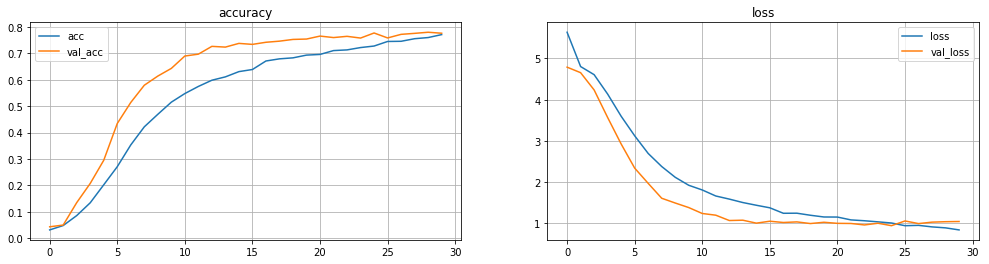

In [10]:
# Plot learning curves
fig = plt.figure(figsize = (17, 4))
    
plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
#plt.plot(history.history['acc'], label = 'acc')
#plt.plot(history.history['val_acc'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [11]:
# Loading weights from best model
#model.load_weights('../working/best_model.hdf5')
model.load_weights('/root/userspace/private/competition/best_model_7.hdf5')

# Saving all model
#model.save('../working/model.hdf5')
model.save('/root/userspace/private/competition/model_7.hdf5')

In [12]:
mewtwo = ['https://cdn.bulbagarden.net/upload/thumb/7/78/150Mewtwo.png/250px-150Mewtwo.png',
         'https://cdn.vox-cdn.com/thumbor/sZPPvUyKyF97UEU-nNtVnC3LpF8=/0x0:1750x941/1200x800/filters:focal(878x316:1158x596)/cdn.vox-cdn.com/uploads/chorus_image/image/63823444/original.0.jpg',
         'https://images-na.ssl-images-amazon.com/images/I/61j5ozFjJ0L._SL1024_.jpg']

pikachu = ['https://lh3.googleusercontent.com/proxy/DrjDlKlu9YonKbj3iNCJNJ3DGqzy9GjeXXSUv-TcVV4UN9PMCAM5yIkGLPG7wYo3UeA4sq5OmUWM8M6K5hy2KOAhf8SOL3zPH3axb2Xo3HX2XTU8M2xW4X6lVg=w720-h405-rw',
          'https://giantbomb1.cbsistatic.com/uploads/scale_medium/0/6087/2437349-pikachu.png',
          'https://johnlewis.scene7.com/is/image/JohnLewis/237525467']

charmander = ['https://img.pokemondb.net/artwork/large/charmander.jpg',
             'https://www.pokemoncenter.com/wcsstore/PokemonCatalogAssetStore/images/catalog/products/P5073/701-03990/P5073_701-03990_01.jpg',
             'https://static.posters.cz/image/750/%D0%A7%D0%B0%D1%88%D0%BA%D0%B0/pokemon-charmander-glow-i72513.jpg']

bulbasaur = ['https://img.pokemondb.net/artwork/large/bulbasaur.jpg',
            'https://ae01.alicdn.com/kf/HTB1aWullxSYBuNjSsphq6zGvVXaR/Big-Size-55-CM-Plush-Toy-Squirtle-Bulbasaur-Charmander-Toy-Sleeping-Pillow-Doll-For-Kid-Birthday.jpg',
            'https://cdn.bulbagarden.net/upload/thumb/f/f7/Bulbasaur_Detective_Pikachu.jpg/250px-Bulbasaur_Detective_Pikachu.jpg']

squirtle = ['https://assets.pokemon.com/assets/cms2/img/pokedex/full/007.png',
           'https://cdn.vox-cdn.com/thumbor/l4cKX7ZWargjs-zlxOSW2WZVgfI=/0x0:2040x1360/1200x800/filters:focal(857x517:1183x843)/cdn.vox-cdn.com/uploads/chorus_image/image/61498573/jbareham_180925_ply0802_0030.1537570476.jpg',
           'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Fdavidthier%2Ffiles%2F2018%2F07%2FSquirtle_Squad.jpg']

test_df = [mewtwo, pikachu, charmander, bulbasaur, squirtle]

In [13]:
# Lists to store our future data
val_x = []
val_y = []

for i, urls in enumerate(test_df):
    for url in urls:        
        r = requests.get(url, stream = True).raw
        image = np.asarray(bytearray(r.read()), dtype="uint8")
        image = cv.imdecode(image, cv.IMREAD_COLOR)
        val_x.append(image)
        val_y.append(i)

# plt.imshow(image[:, :, ::-1])

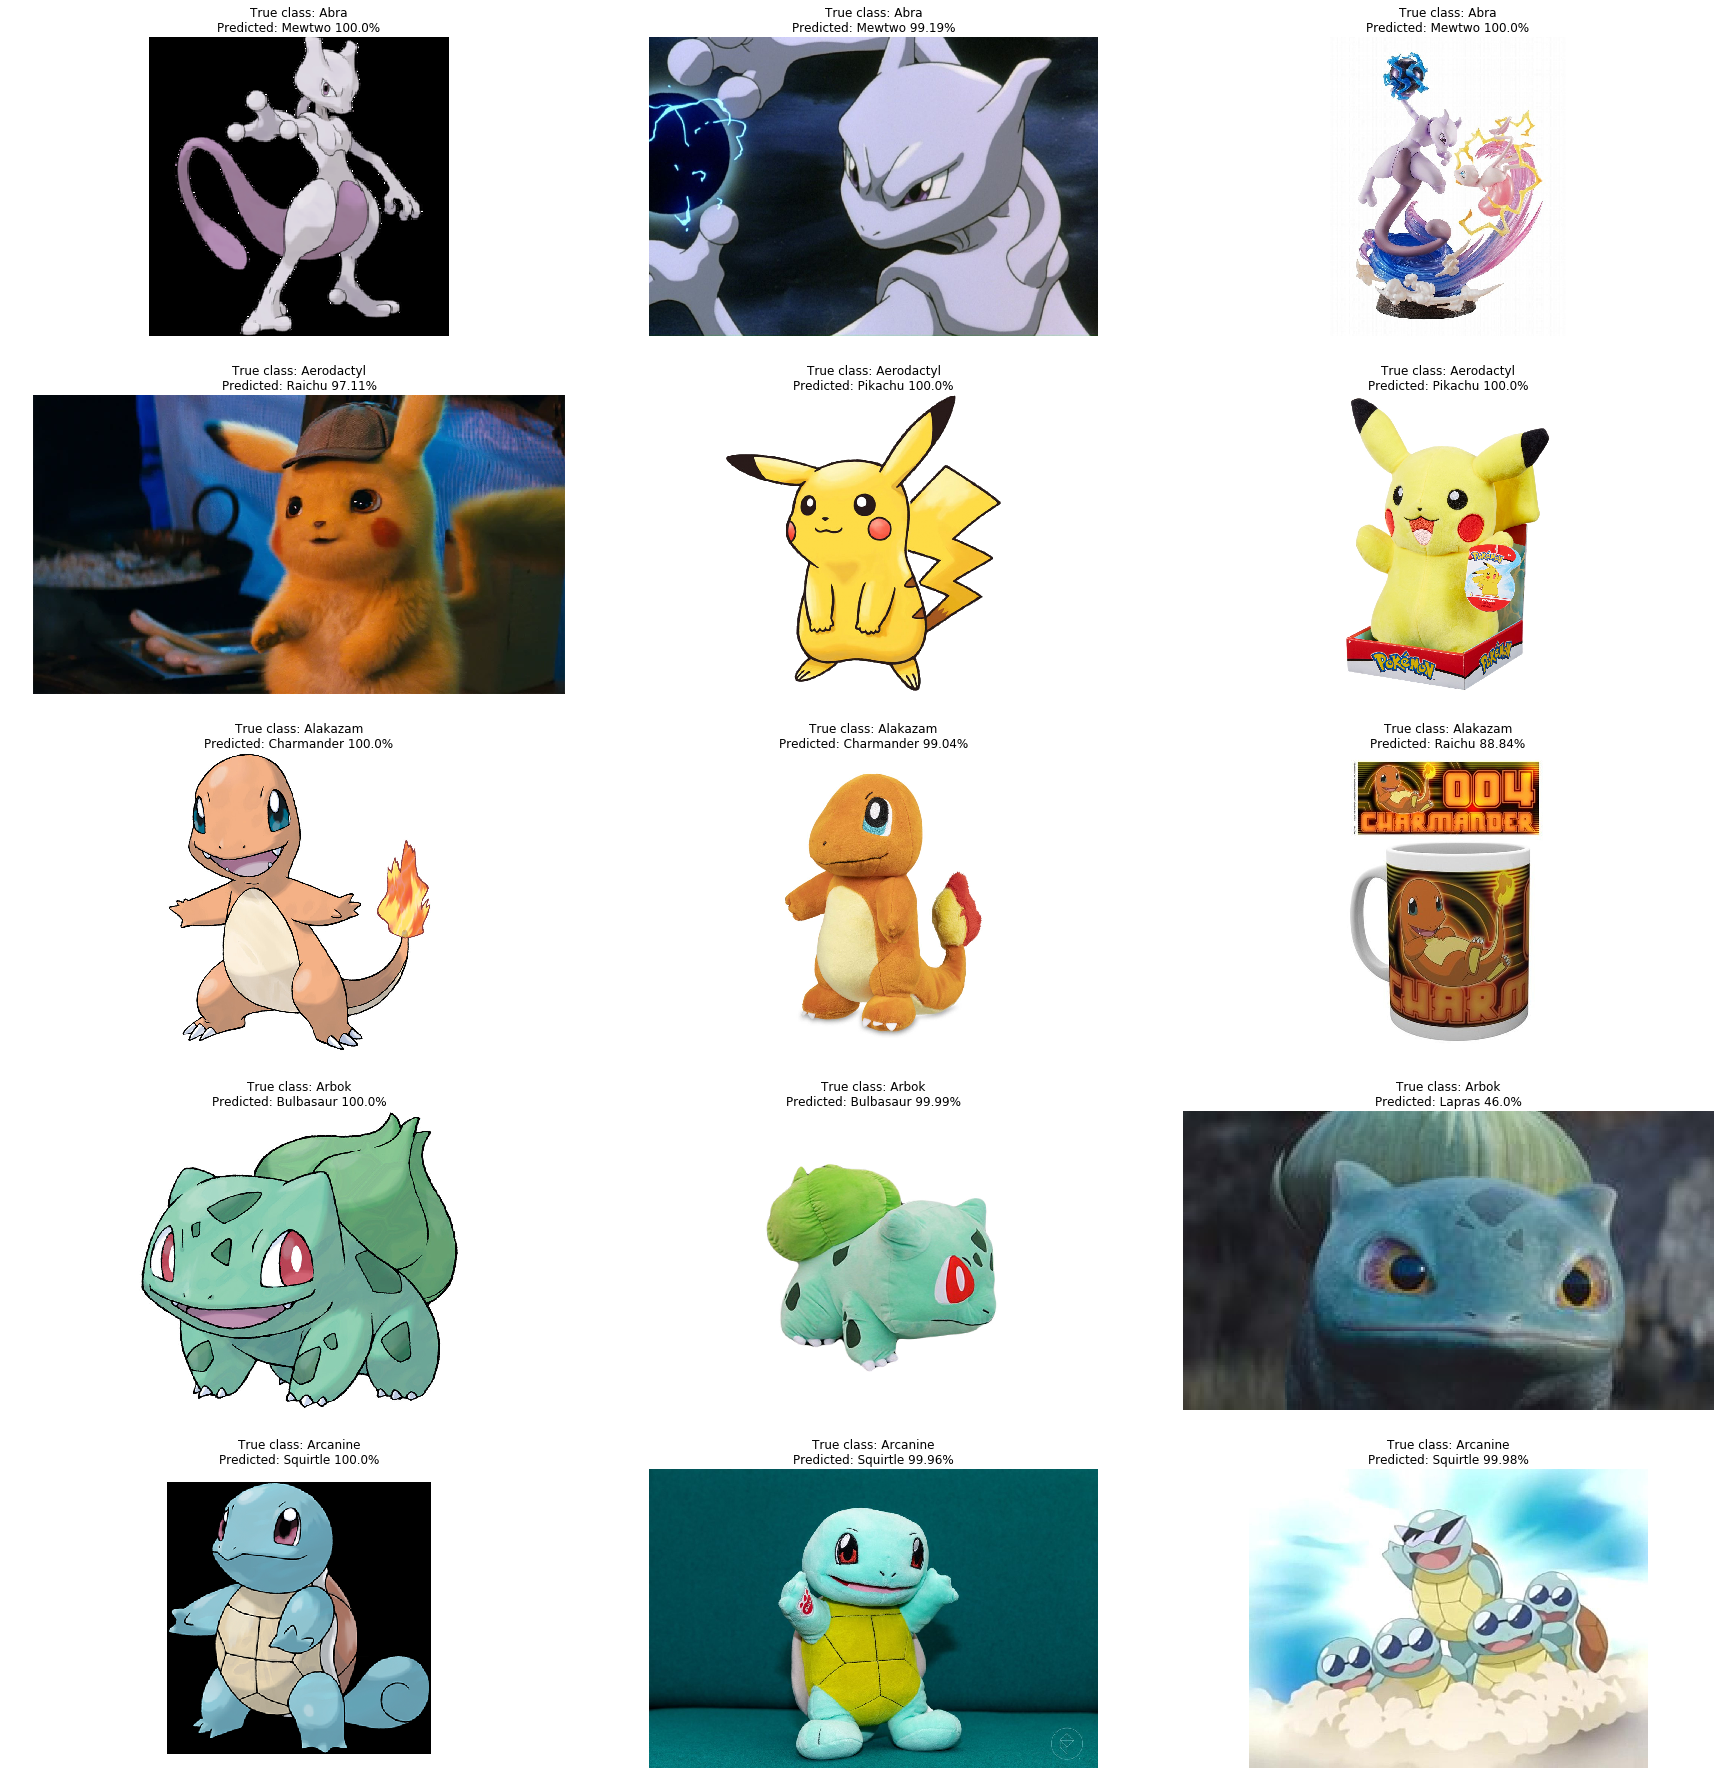

In [14]:
rows = 5
cols = 3

fig = plt.figure(figsize = (25, 25))

for i, j in enumerate(zip(val_x, val_y)): # i - for subplots
    orig = j[0] # Original, not resized image
    label = j[1] # Label for that image
    
    #image = cv.resize(orig, (96, 96)) # Resizing image to (96, 96)
    #image = image.reshape(-1, 96, 96, 3) / 255.0 # Reshape and scale resized image
    image = cv.resize(orig, (196, 196)) # Resizing image to (196, 196)
    image = image.reshape(-1, 196, 196, 3) / 255.0 # Reshape and scale resized image
    preds = model.predict(image) # Predicting image
    pred_class = np.argmax(preds) # Defining predicted class
    
    true_label = f'True class: {imbalanced[label]}'
    pred_label = f'Predicted: {imbalanced[pred_class]} {round(preds[0][pred_class] * 100, 2)}%'
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(orig[:, :, ::-1])
    plt.title(f'{true_label}\n{pred_label}')
    plt.axis('off')
    
plt.tight_layout()